<a href="https://colab.research.google.com/github/kenyam1979/Test-colab/blob/main/Test_PS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
library(tidyverse)

In [10]:
data <- read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")

Rows: 64000 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): history_segment, zip_code, channel, segment
dbl (8): recency, history, mens, womens, newbie, visit, conversion, spend

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
head(data)

recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0
6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0
7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0
9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0
2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0
6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0


In [14]:
data.male <- data %>% 
  filter(segment != "Womens E-Mail") %>%
  mutate(treatment = if_else(segment == "Mens E-Mail", 1, 0))

In [15]:
set.seed(1)
data.male.biased <- data.male %>%
  mutate(obs.rate.c = if_else(
    (history > 300) | (recency < 6) | (channel == "Multichannel"), 
    0.5, 1),
    obs.rate.t = if_else(
      (history > 300) | (recency < 6) | (channel == "Multichannel"), 
      1, 0.5),
      random.number = runif(n = NROW(data.male))) %>%
      filter((treatment == 0 & random.number < obs.rate.c) | (treatment == 1 & random.number < obs.rate.t)) 


Warning message:
“Removed 31559 rows containing non-finite values (stat_boxplot).”


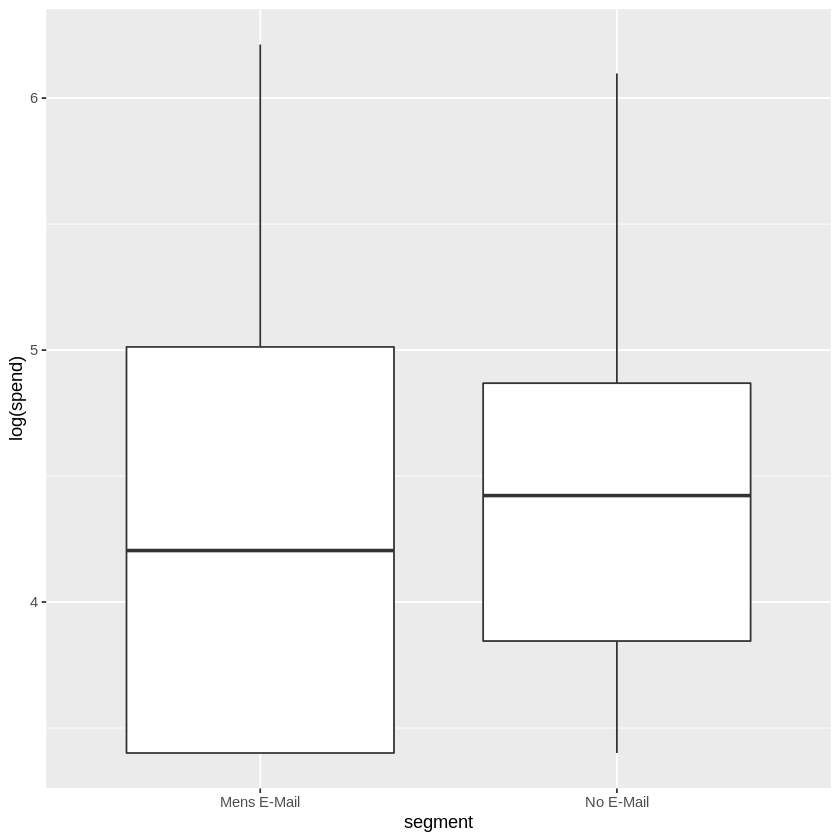

In [16]:
data.male.biased %>%
  group_by(segment) %>%
  ggplot() + geom_boxplot(aes(x = segment, y=log(spend)))



In [26]:
model <- lm(data=data.male.biased, formula = spend ~ treatment)
summary(model)


Call:
lm(formula = spend ~ treatment, data = data.male.biased)

Residuals:
   Min     1Q Median     3Q    Max 
 -1.53  -1.53  -1.53  -0.55 497.47 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.5483     0.1269   4.321 1.56e-05 ***
treatment     0.9794     0.1727   5.671 1.43e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.37 on 31861 degrees of freedom
Multiple R-squared:  0.001008,	Adjusted R-squared:  0.000977 
F-statistic: 32.16 on 1 and 31861 DF,  p-value: 1.433e-08


##Propensity score + IPW

In [43]:
ps.model <- glm(data=data.male.biased, formula= treatment ~ recency + history + channel, family = binomial)
data.male.biased <- data.male.biased %>% 
  mutate(ps = predict(ps.model, type="response")) %>%
  mutate(IPW = if_else(treatment == 1, 1/ps, 1/(1 - ps)))

In [45]:
model.IPW <- lm(data=data.male.biased, formula = spend ~ treatment, weights=data.male.biased$IPW)
summary(model.IPW)


Call:
lm(formula = spend ~ treatment, data = data.male.biased, weights = data.male.biased$IPW)

Weighted Residuals:
   Min     1Q Median     3Q    Max 
 -2.60  -1.91  -1.68  -0.82 883.53 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.5805     0.1163   4.992 6.01e-07 ***
treatment     0.8697     0.1650   5.272 1.36e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20.85 on 31861 degrees of freedom
Multiple R-squared:  0.0008716,	Adjusted R-squared:  0.0008403 
F-statistic:  27.8 on 1 and 31861 DF,  p-value: 1.357e-07
